# ATC project: Pupil dilatation model 

Create a circular pupil model and check whether the created video makes sense. 

Pupil model will use tracking from DLC that includes: 
- tear
- wrikle
- eye_center
- eye12hs
- eye6hs
- eye3hs
- eye9hs
- eye1.30hs
- eye4.30hs
- eye7.30hs
- eye10.30hs

For pupil diameter we will use multiple measures:

- Mean from center to clock points.
- Distance between pair of opossite points. 

For exact position after sacades will use relative movement from center or artificial center (mean over clock) to teat and wrinkle.

Points in the tracking will be taken into consideration if they have an aceptable level of likelihood.

''' Oct 17th 2022'''


In [307]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pathlib import Path
from collections import namedtuple
import random
import scipy.signal as ssignal
from sklearn.linear_model import LinearRegression

### scale definition for converting pixel distance to cm diameter
npixel = 500
size = 400
pscale = size / npixel
frate = 30

### Thresholds for ethogram building
LIKELIHOOD_LIM = 0.9
def center_model(position, likelihood_threshold = 0.5):
    
    center_position_model = np.zeros((2,))
    count = 0
    sum_x = 0
    sum_y = 0
    for i in range(8):
        if position[i,2] > likelihood_threshold:
            sum_x += position[i,0]
            sum_y += position[i,1]
            count+=1
    center_position_model[0] = sum_x / count
    center_position_model[1] = sum_y / count
    
    return center_position_model

def radius_model(position, center_position, likelihood_threshold, model_id):
    
    count = 0
    sum_rad = 0
    
    for i in range(8):
        if position[i,2] > likelihood_threshold:
            sum_rad += np.sqrt((position[i,0]-center_position[0])**2 + (position[i,1]-center_position[1])**2)
            count+=1

    return sum_rad / count

def shape_model(position, likelihood_threshold,model_id):
    
    '''
    Create a model circular model for pupil.
    
    input -> tracking: numpy array, contains positions along the eye. 
    Here we use the convetion for labeling: center,eye12,eye6,eye3,eye9,eye1.30,eye4.30,eye7.30,eye10.30.
    
    output -> shape : tupple, that contains the model for radius and center
    
    '''
    #center_value
    center_data = np.zeros((2,))
    center_m = center_model(position[1:,:],likelihood_threshold)

    if position[0,2] > likelihood_threshold:
        center_data[0] = position[0,0]
        center_data[1] = position[0,1]
    else:
        center_data = center_m
        
    
    radius_1 = radius_model(position[1:,:], center_data, likelihood_threshold,model_id)
    radius_2 = radius_model(position[1:,:], center_m, likelihood_threshold,model_id)

    shape = namedtuple('shape', ['center','center_model','radius'])
    
    return shape(center_data , center_m, radius_1)

def pupil_model(tracking = None, model_id = 0, likelihood_threshold = 0.8):
    
    '''
    Create a circular model for pupil shape, dilatation. 
    Different version refer to the data that will be use to create the model.
    
    
    input -> tracking : tracking of a 9 positions of the eye
             model_id: version of model to create the pupil:
             0 : mean over radius positions from center
             1 : mean over diameter positions
             
    
    output -> pupil_model: model of the mouse movement in time, that conteins center position and radius.
            center position is recomputed by using the tracking of the 8 points sorrounding the pupil
    
    '''
    model = [shape_model(tracking[:,i,:],model_id,likelihood_threshold) for i in range(tracking.shape[1])]
        
    pupil_model = namedtuple('pupil_model', ['shape_model'])
       
    return pupil_model(model)

### Create a video with the model
import cv2
NTIME = 5000
def create_pupil_dilatation_video(input_video_file, output_video_file,model1):
    
    cap = cv2.VideoCapture(str(input_video_name))
    #cap.set(cv2.CAP_PROP_POS_FRAMES, )
    w = int(video_in.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(video_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
    length = int(video_in.get(cv2.CAP_PROP_FRAME_COUNT))
    
    #fourcc = cv.VideoWriter_fourcc('m', 'p', '4', 'v')
    #writer = cv.VideoWriter(file_path, fourcc, fps, (w, h))
    output = cv2.VideoWriter(str(output_video),cv2.VideoWriter_fourcc(*'MJPG'),20,(w,h))

    center = [model1.shape_model[frame_n].center.astype(int) for frame_n in range(len(model1.shape_model))]

    offset = length - len(center)

    for frame_n in range(length-offset):

        r , frame = cap.read()    
        if frame_n > offset:
            center1 = model1.shape_model[frame_n-offset].center.astype(int)
            radius1 = model1.shape_model[frame_n-offset].radius.astype(int) 
            cv2.circle(frame, tuple(center1),radius1, color = (255,0,0), thickness = 3)
        
        
        output.write(frame)
    
    return

In [308]:
## load tracking information
tracking_path = Path('/home/melisamc/Documentos/ATC_project/data/pupil_dilatation/DLC_tracking/')
tracking_path.exists()
input_file_name = 'Basler_acA1920-155um__23267064__20201102_121214379DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv'
tracking_DFrame = pd.read_csv(tracking_path / input_file_name)

tracking_path ='/home/melisamc/Documentos/ATC_project/data/pupil_dilatation/'
input_video_name = tracking_path + 'videos/Basler_acA1920-155um__23267064__20201102_121214379.mp4'
output_video = tracking_path + 'pupil_tracking_example.avi'

figures_path = '/home/melisamc/Documentos/ATC_project/figures/'


In [309]:
tracking_DFrame

scorer DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000  \
0      bodyparts                                           tear   
1         coords                                              x   
2              0                              871.3253784179688   
3              1                              871.1075439453125   
4              2                              870.0191650390625   
...          ...                                            ...   
10536      10534                              861.6387939453125   
10537      10535                              862.5553588867188   
10538      10536                              862.8719482421875   
10539      10537                              862.6795654296875   
10540      10538                              862.9251708984375   

      DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.1  \
0                                                 tear   
1                                                    y   
2                                    464.3075866699219   
3                                   463.80950927734375   
4                                    462.3861389160156   
...                                                ...   
10536                               464.58392333984375   
10537                                463.4789733886719   
10538                               462.67938232421875   
10539                                463.5627136230469   
10540                                463.3978576660156   

      DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.2  \
0                                                 tear   
1                                           likelihood   
2                                   0.9798403978347778   
3                                   0.9767483472824097   
4                                   0.9684432148933411   
...                                                ...   
10536                               0.9716740250587463   
10537                               0.9676862955093384   
10538                               0.9656485915184021   
10539                               0.9705761671066284   
10540                               0.9739267230033875   

      DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.3  \
0                                              wrinkle   
1                                                    x   
2                                   1104.3651123046875   
3                                   1103.2420654296875   
4                                   1104.3475341796875   
...                                                ...   
10536                               1104.2178955078125   
10537                               1104.5562744140625   
10538                               1104.7559814453125   
10539                               1104.7396240234375   
10540                                1104.533447265625   

      DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.4  \
0                                              wrinkle   
1                                                    y   
2                                      521.67529296875   
3                                      522.77001953125   
4                                    520.1544189453125   
...                                                ...   
10536                                515.2672729492188   
10537                                515.6869506835938   
10538                                  515.35791015625   
10539                                515.6824340820312   
10540                                515.8110961914062   

      DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.5  \
0                                              wrinkle   
1                                           likelihood   
2                                   0.9860265254974365   
3                                   0.9822638034820557   
4                                   0.9929497241973877   
...                                                ...   
10536      

In [310]:
## get body parts from tracking fil
eye_parts = [tracking_DFrame.iloc[0][i*3+1] for i in range(int(len(tracking_DFrame.iloc[0])/3))]
eye_part_structure = [tracking_DFrame.iloc[1][i+1] for i in range(3)]

print(eye_part_structure)
tracking_DFrame = tracking_DFrame.iloc[0:]

['x', 'y', 'likelihood']


In [311]:
# convert tracking pandas to numpy
tracking_DFrame = tracking_DFrame.iloc[2:]
tracking_DFrame = tracking_DFrame.astype(float)
tracking_data = tracking_DFrame.to_numpy()
print(tracking_data.shape)
eye_tracking = tracking_data[:,1+2*3:];
tracking = np.array([eye_tracking[:,[i*3,i*3+1,i*3+2]] for i in range(9)])
print(tracking.shape)

(10539, 34)
(9, 10539, 3)


In [288]:
pupil_model_radius = pupil_model(tracking)
print(input_video_name)
print(output_video)
#create_pupil_dilatation_video(input_video_name, output_video,pupil_model_radius)

In [289]:
center1 = [pupil_model_radius.shape_model[frame_n].center for frame_n in range(len(pupil_model_radius.shape_model))]
radius = [pupil_model_radius.shape_model[frame_n].radius for frame_n in range(len(pupil_model_radius.shape_model))]

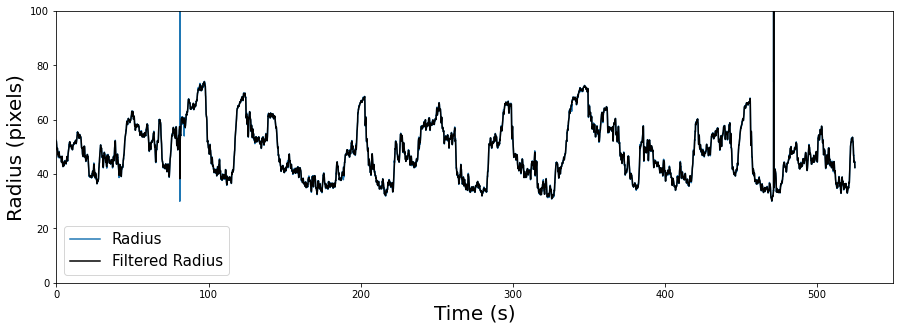

In [312]:
figure, axes = plt.subplots()
time = np.arange(0,len(radius))/20
smothed_radius = ssignal.medfilt(radius,3)

axes.plot(time,radius)
axes.plot(time,smothed_radius,c = 'k')

axes.set_xlim([0,550])
axes.set_ylim([0,100])

axes.set_xlabel('Time (s)', fontsize = 20)
axes.set_ylabel('Radius (pixels)', fontsize = 20)

axes.legend(['Radius','Filtered Radius'],fontsize = 15)
figure.set_size_inches([15,5])
figure.savefig(figures_path + 'radius_A04.png')

In [314]:
input_file_name_list = ['Basler_acA1920-155um__23267064__20201102_121214379DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201102_123005525DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201102_125049379DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201102_130701997DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201102_132416244DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201104_111355375DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201104_113459286DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201104_115418532DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201104_121219490DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201104_123051148DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201106_104409501DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201106_110206061DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201106_111928346DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201106_114627258DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201108_122655100DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201108_124420605DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201108_130101806DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201108_131845698DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201111_122334594DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201111_124018651DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201111_125718055DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201111_131506374DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201113_124848427DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201113_130511789DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201113_132120510DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201113_133732072DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201115_140636021DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201115_142430969DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201115_144150725DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201115_150244194DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201117_122637755DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201117_124422091DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201117_131012154DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv',
                        'Basler_acA1920-155um__23267064__20201117_133429441DLC_resnet50_ATC_pupils_A04okt13shuffle1_50000.csv']


In [315]:
len(input_file_name_list)

34

In [326]:
output_path = '/home/melisamc/Documentos/ATC_project/data/pupil_dilatation/output/'
tracking_path = Path('/home/melisamc/Documentos/ATC_project/data/pupil_dilatation/DLC_tracking/')

for i in range(len(input_file_name_list)):
    tracking_DFrame = pd.read_csv(tracking_path / input_file_name_list[i])
    ## get body parts from tracking fil
    eye_parts = [tracking_DFrame.iloc[0][i*3+1] for i in range(int(len(tracking_DFrame.iloc[0])/3))]
    eye_part_structure = [tracking_DFrame.iloc[1][i+1] for i in range(3)]

    print(eye_part_structure)
    tracking_DFrame = tracking_DFrame.iloc[0:]
    # convert tracking pandas to numpy
    tracking_DFrame = tracking_DFrame.iloc[2:]
    tracking_DFrame = tracking_DFrame.astype(float)
    tracking_data = tracking_DFrame.to_numpy()
    print(tracking_data.shape)
    eye_tracking = tracking_data[:,1+2*3:];
    tracking = np.array([eye_tracking[:,[i*3,i*3+1,i*3+2]] for i in range(9)])
    print(tracking.shape)
    pupil_model_radius = pupil_model(tracking)
    center1 = np.array([pupil_model_radius.shape_model[frame_n].center for frame_n in range(len(pupil_model_radius.shape_model))])
    radius = np.array([pupil_model_radius.shape_model[frame_n].radius for frame_n in range(len(pupil_model_radius.shape_model))])
    
    radius_name = output_path + input_file_name_list[i][0:50] + '_radius.npy'
    center_name = output_path + input_file_name_list[i][0:50] + '_center.npy'
    
    np.save(radius_name,radius)
    np.save(center_name,center1)

['x', 'y', 'likelihood']
(10539, 34)
(9, 10539, 3)
['x', 'y', 'likelihood']
(10535, 34)
(9, 10535, 3)
['x', 'y', 'likelihood']
(10538, 34)
(9, 10538, 3)
['x', 'y', 'likelihood']
(10536, 34)
(9, 10536, 3)
['x', 'y', 'likelihood']
(10537, 34)
(9, 10537, 3)
['x', 'y', 'likelihood']
(10560, 34)
(9, 10560, 3)
['x', 'y', 'likelihood']
(10520, 34)
(9, 10520, 3)
['x', 'y', 'likelihood']
(10513, 34)
(9, 10513, 3)
['x', 'y', 'likelihood']
(10515, 34)
(9, 10515, 3)
['x', 'y', 'likelihood']
(10514, 34)
(9, 10514, 3)
['x', 'y', 'likelihood']
(10510, 34)
(9, 10510, 3)
['x', 'y', 'likelihood']
(10508, 34)
(9, 10508, 3)
['x', 'y', 'likelihood']
(10513, 34)
(9, 10513, 3)
['x', 'y', 'likelihood']
(10511, 34)
(9, 10511, 3)
['x', 'y', 'likelihood']
(10504, 34)
(9, 10504, 3)
['x', 'y', 'likelihood']
(10511, 34)
(9, 10511, 3)
['x', 'y', 'likelihood']
(10510, 34)
(9, 10510, 3)
['x', 'y', 'likelihood']
(10512, 34)
(9, 10512, 3)
['x', 'y', 'likelihood']
(10505, 34)
(9, 10505, 3)
['x', 'y', 'likelihood']
(10531

In [373]:
input_file_name_list = ['Basler_acA1920-155um__23267064__20201106_104409501_radius.npy',
                        'Basler_acA1920-155um__23267064__20201106_110206061_radius.npy',
                        'Basler_acA1920-155um__23267064__20201106_111928346_radius.npy',
                        'Basler_acA1920-155um__23267064__20201106_114627258_radius.npy']

input_file_name_list = ['Basler_acA1920-155um__23267064__20201108_122655100_radius.npy',
                        'Basler_acA1920-155um__23267064__20201108_124420605_radius.npy',
                        'Basler_acA1920-155um__23267064__20201108_130101806_radius.npy',
                        'Basler_acA1920-155um__23267064__20201108_131845698_radius.npy']

radius = []

for i in range(4):
    radius.append(np.load(output_path + input_file_name_list[i]))

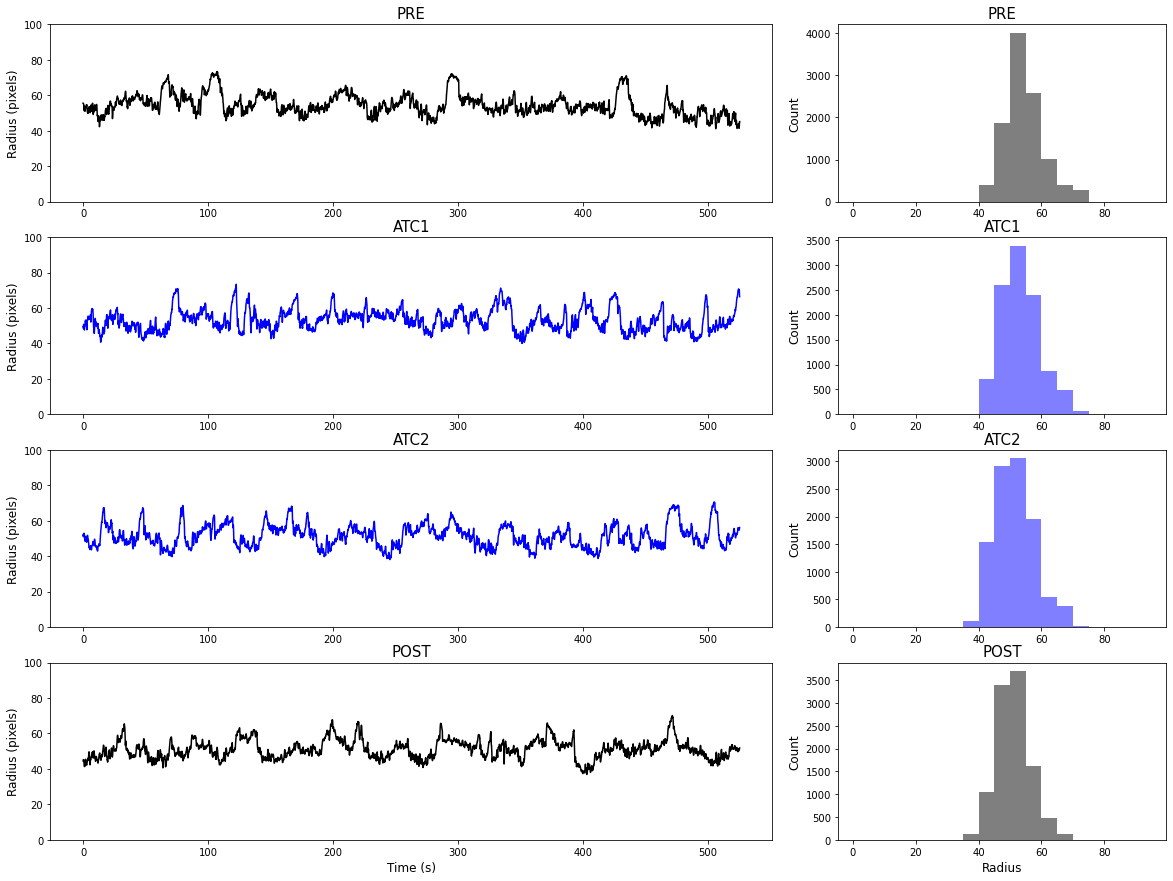

In [374]:
figure = plt.figure()

titles = ['PRE','ATC1','ATC2','POST']
colors = ['k','b','b','k']

gs = plt.GridSpec(4,3)

bins = np.arange(0,100,5)
for i in range(4):
    axes = figure.add_subplot(gs[i,0:2])
    r = radius[i]
    time = np.arange(0,len(r))/20
    smothed_radius = ssignal.medfilt(r,3)
    axes.plot(time,smothed_radius,color = colors[i])
    axes.set_ylim([0,100])
    if i == 3:
        axes.set_xlabel('Time (s)', fontsize = 12)
    axes.set_ylabel('Radius (pixels)', fontsize = 12)
    axes.set_title(titles[i],fontsize = 15)
    
    axes = figure.add_subplot(gs[i,2])
    axes.hist(radius[i],bins = bins, color = colors[i],alpha = 0.5)
    if i ==3:
        axes.set_xlabel('Radius', fontsize = 12)
    axes.set_ylabel('Count',fontsize = 12)
    axes.set_title(titles[i],fontsize = 15)

    
figure.set_facecolor('white')
   
figure.set_size_inches([20,15])
figure.savefig(figures_path + 'Basler_acA1920-155um__23267064__20201108.png')

In [364]:

    output_path + radius_file_name_list[i]

'/home/melisamc/Documentos/ATC_project/data/pupil_dilatation/output/Basler_acA1920-155um__23267064__20201106_114627258_radius.npy'